In [6]:
#Imports

import copy
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from matplotlib.ticker import FuncFormatter

In [7]:
# Define a function to format the ticks with 2 decimal places
def format_ticks(value, _):
    return f'{value:.3f}'

In [8]:
energy_types = ["Load", "PV", "Prosumpt"]
directory = "results/"
pattern = re.compile(r'\d+')

organized_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))


for energy_type in energy_types:
    for filename in os.listdir(directory):
        if energy_type in filename and '_all_' in filename  and 'ClustersANDRetrained' in filename and filename.endswith('.pkl'):

            distribution = filename.split('_')[3]
            match = re.match(r"([a-zA-Z]+)(\d+)", distribution)

            if match:
                distribution_part = match.group(1).upper()  # Convert the alphabetic part to uppercase
                noise_part = match.group(2)
            else:
                distribution_part = "noAttack"
                noise_part = "0"

            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                
                organized_results[energy_type][distribution_part][noise_part]["cnn"] = data["cnn_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["bilstm"] = data["bilstm_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["softdense"] = data["softdense_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["softlstm"] = data["softlstm_all_results"]

# Convert the defaultdict back to a regular dictionary (if desired)
organized_results = dict(organized_results)

In [9]:
organized_results["Load"]["NORMD"]["02"].keys()

dict_keys(['cnn', 'bilstm', 'softdense', 'softlstm'])

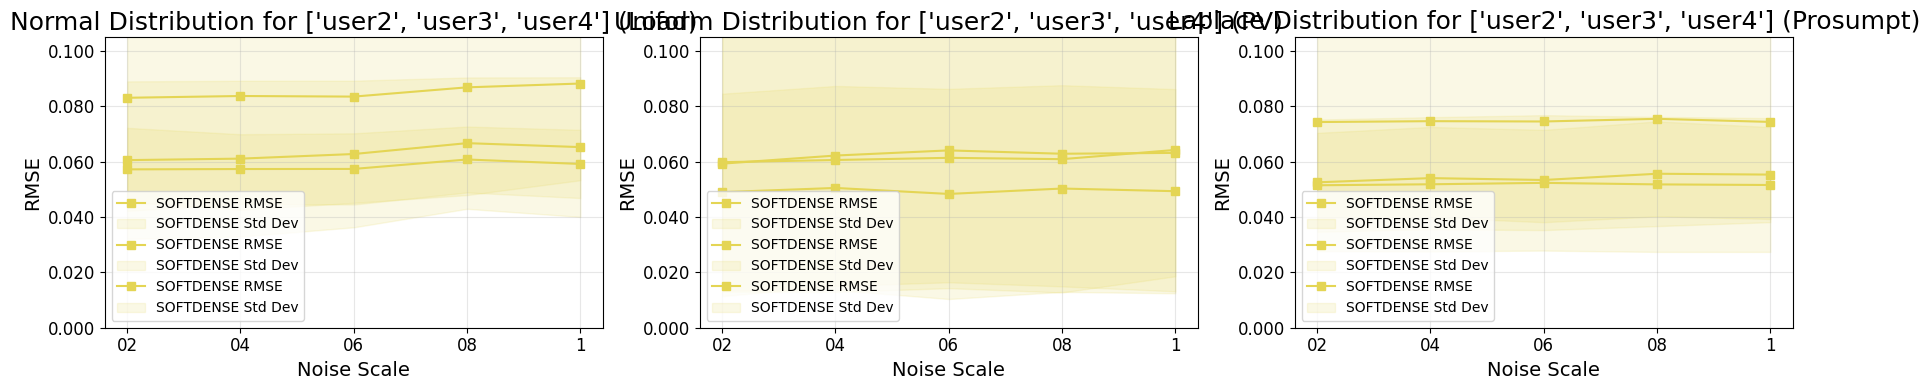

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Energy types and their corresponding distributions
energy_types = ["Load", "PV", "Prosumpt"]
distributions = {
    "Load": "NORMD",
    "PV": "UNID",
    "Prosumpt": "LAPD"
}

noise_levels = ["0", "02", "04", "06", "08", "1"]
user_plot = ["user2", "user3", "user4"]
models = ["softdense"] #"bilstm", , "softlstm"
global_min_rmse = float('inf')
global_max_rmse = float('-inf')
offset = 0.001

# Create subplots for each energy type
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 3 columns for the 3 energy types
axes = axes.flatten()

# Iterate over each energy type and its corresponding distribution
for idx, energy_type in enumerate(energy_types):
    distribution = distributions[energy_type]
    ax = axes[idx]  # Select the correct subplot axis
    
    for model in models:
            
        for user in user_plot:

            # DataFrame to collect the mean values of rmse and std for the specified user across different noise scales
            mean_results = {"noise": [], "rmse": [], "std": []}
            
            # Iterate over each noise level and calculate the mean and std for the specified user and model
            for noise in noise_levels:
                try:
                    if noise == "0":
                        # Special case: Use the data from the 'noAttack' distribution for 'noNoise'
                        df = organized_results[energy_type]["noAttack"]["0"][model]
                    else:
                        df = organized_results[energy_type][distribution][noise][model]

                    user_df = df[df["user"] == user]
                    mean_results["noise"].append(noise)
                    mean_results["rmse"].append(user_df["rmse"].mean())
                    mean_results["std"].append(user_df["rmse"].std())

                    rmse_mean = user_df["rmse"].mean()
                    if rmse_mean < global_min_rmse:
                        global_min_rmse = rmse_mean
                    if rmse_mean > global_max_rmse:
                        global_max_rmse = rmse_mean
                except KeyError:
                    # If the data for a specific noise level does not exist, skip it
                    continue

            # Convert the mean results into a DataFrame for easy plotting
            mean_df = pd.DataFrame(mean_results)

            # Define marker and color for each model
            if model == "bilstm":
                color = "#294586"
                marker = 'o'
            elif model == "softdense":
                color = "#E4D554"
                marker = 's'
            elif model == "softlstm":
                color = "#903045"
                marker = '^'

            # Plot the mean RMSE for the model
            ax.plot(mean_df["noise"], mean_df["rmse"], label=f"{model.upper()} RMSE", marker=marker, color=color)
            
            # Plot the standard deviation as a transparent shaded area for the model
            ax.fill_between(mean_df["noise"], mean_df["rmse"] - mean_df["std"], mean_df["rmse"] + mean_df["std"], color=color, alpha=0.15, label=f"{model.upper()} Std Dev")

    # Set title, labels, and grid for each subplot
    distribution_names = {
        "UNID": "Uniform Distribution",
        "BUILDD": "Buildings Distribution",
        "LAPD": "Laplace Distribution",
        "NORMD": "Normal Distribution"
    }
    
    ax.set_title(f"{distribution_names[distribution]} for {user_plot} ({energy_type})", fontsize=18)
    ax.set_xlabel("Noise Scale", fontsize=14)
    ax.set_ylabel("RMSE", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    #ax.set_ylim(global_min_rmse - offset, global_max_rmse + offset)
    ax.legend()
    ax.grid(True, alpha=0.3)

    for ax in axes:
        ax.set_ylim(0, 0.105)

# Adjust layout to ensure titles and labels are properly spaced
plt.tight_layout()
#plt.savefig(f"figures/{user_plot}_rmse_plot_energy_types.pdf")
plt.show()


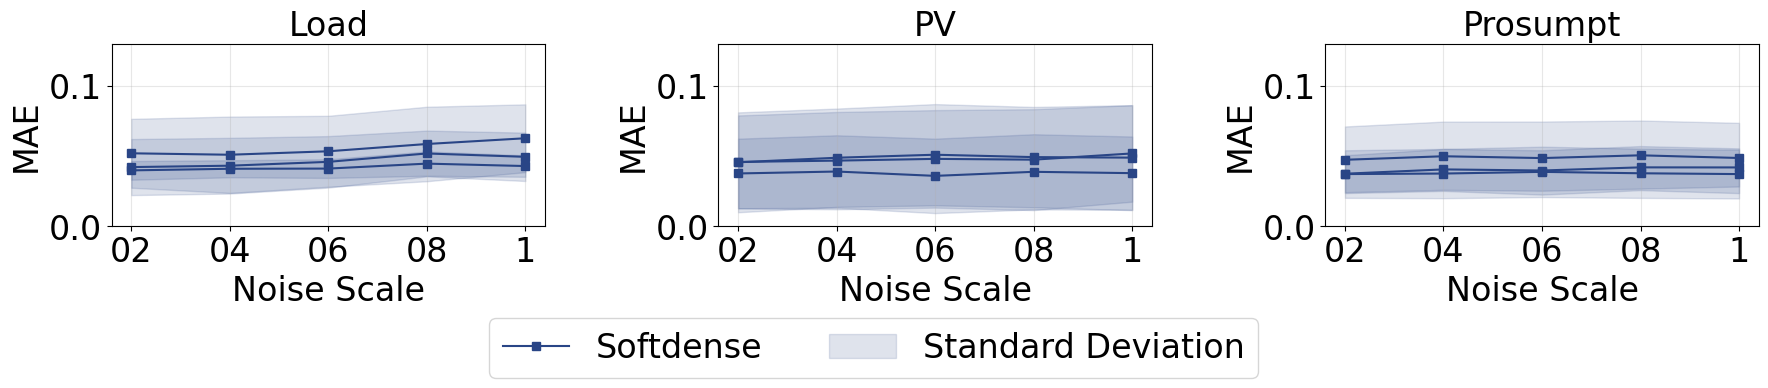

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Energy types and their corresponding distributions
energy_types = ["Load", "PV", "Prosumpt"]
distributions = {
    "Load": "NORMD",
    "PV": "UNID",
    "Prosumpt": "LAPD"
}

noise_levels = ["0", "02", "04", "06", "08", "1"]
user_plot = ["user2", "user3", "user4"]
models = ["softdense"]  # Only softdense model is used in this case

# Create subplots for each energy type
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 3 columns for the 3 energy types
axes = axes.flatten()

# To store handles and labels for the combined legend
handles, labels = [], []

# Iterate over each energy type and its corresponding distribution
for idx, energy_type in enumerate(energy_types):
    distribution = distributions[energy_type]
    ax = axes[idx]  # Select the correct subplot axis

    for model in models:
        for user in user_plot:

            # DataFrame to collect the mean values of mae and std for the specified user across different noise scales
            mean_results = {"noise": [], "mae": [], "std": []}

            # Iterate over each noise level and calculate the mean and std for the specified user and model
            for noise in noise_levels:
                try:
                    if noise == "0":
                        # Special case: Use the data from the 'noAttack' distribution for 'noNoise'
                        df = organized_results[energy_type]["noAttack"]["0"][model]
                    else:
                        df = organized_results[energy_type][distribution][noise][model]

                    user_df = df[df["user"] == user]
                    mean_results["noise"].append(noise)
                    mean_results["mae"].append(user_df["mae"].mean())
                    mean_results["std"].append(user_df["mae"].std())

                    mae_mean = user_df["mae"].mean()

                except KeyError:
                    # If the data for a specific noise level does not exist, skip it
                    continue

            # Convert the mean results into a DataFrame for easy plotting
            mean_df = pd.DataFrame(mean_results)

            # Define marker and color for each model
            line_color = "#294586"  # The color for softdense model line
            fill_color = "#294586"  # The blue color for the std fill from bilstm
            marker = 's'

            # Plot the mean MAE for the model
            line, = ax.plot(mean_df["noise"], mean_df["mae"], label=f"{model.title()}", marker=marker, color=line_color)

            # Plot the standard deviation as a transparent shaded area in blue
            fill = ax.fill_between(mean_df["noise"], mean_df["mae"] - mean_df["std"], mean_df["mae"] + mean_df["std"], color=fill_color, alpha=0.15)

            # Collect handles and labels only once per model
            if not handles:
                handles.extend([line, fill])
                labels.extend([f"{model.title()}", "Standard Deviation"])

    # Set title, labels, and grid for each subplot
    distribution_names = {
        "UNID": "Uniform Distribution",
        "BUILDD": "Buildings Distribution",
        "LAPD": "Laplace Distribution",
        "NORMD": "Normal Distribution"
    }

    ax.set_title(f"{energy_type}", fontsize=24)
    ax.set_xlabel("Noise Scale", fontsize=24)
    ax.set_ylabel("MAE", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.grid(True, alpha=0.3)

    for ax in axes:
        ax.set_ylim(0, 0.13)

# Adjust layout to ensure titles and labels are properly spaced
fig.tight_layout(rect=[0, 0.18, 1, 1])  # Reserve space at the bottom for legend
#fig.legend(models, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=16)
# Add the customized legend below all plots
plt.subplots_adjust(hspace=0.5, wspace=0.4) 
fig.legend(handles,labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=2, fontsize=24)



plt.savefig("figures/Security.pdf")
# Show the plot
plt.show()
